In [1]:
import numpy as np
import yaml
import pandas as pd
import nibabel as nib
from nibabel import imagestats
import nilearn
from nilearn.input_data import NiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_epi
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')
import h5py

## MODEL TO LOAD ##
model_name = "nsdflat_large"
outdir = os.path.abspath(f'checkpoints/{model_name}')
print("outdir", outdir)
# Load previous config.yaml if available
if os.path.exists(f"{outdir}/config.yaml"):
    config = yaml.load(open(f"{outdir}/config.yaml", 'r'), Loader=yaml.FullLoader)
    print(f"Loaded config.yaml from ckpt folder {outdir}")
    # create global variables from the config
    print("\n__CONFIG__")
    for attribute_name in config.keys():
        print(f"{attribute_name} = {config[attribute_name]}")
        globals()[attribute_name] = config[f'{attribute_name}']
    print("\n")

import glmsingle
from glmsingle.glmsingle import GLM_single

%matplotlib inline 
%autosave 5

def zscore(data,train_mean=None,train_std=None):
    # assuming that first dim is num_samples and second dim is num_voxels
    if train_mean is None:
        train_mean = np.mean(data,axis=0)
    if train_std is None:
        train_std = np.std(data,axis=0)
    zscored_data = (data - train_mean) / (train_std + 1e-6)
    return zscored_data

outdir /weka/proj-fmri/paulscotti/fMRI-foundation-model/flat/checkpoints/nsdflat_large
Loaded config.yaml from ckpt folder /weka/proj-fmri/paulscotti/fMRI-foundation-model/flat/checkpoints/nsdflat_large

__CONFIG__
base_lr = 0.001
batch_size = 32
ckpt_interval = 5
ckpt_saving = True
cls_embed = True
decoder_embed_dim = 512
grad_accumulation_steps = 1
grad_clip = 1.0
hcp_flat_path = /weka/proj-medarc/shared/NSD-Flat
mask_ratio = 0.75
model_name = nsdflat_large
no_qkv_bias = False
norm_pix_loss = False
num_epochs = 100
num_frames = 16
num_samples_per_epoch = 200000
num_workers = 10
patch_size = 16
pct_masks_to_decode = 1
pred_t_dim = 8
print_interval = 20
probe_base_lr = 0.0003
probe_batch_size = 8
probe_num_epochs = 30
probe_num_samples_per_epoch = 100000
resume_from_ckpt = True
seed = 42
sep_pos_embed = True
t_patch_size = 2
test_num_samples_per_epoch = 50000
test_set = False
trunc_init = False
use_contrastive_loss = False
wandb_log = True




Autosaving every 5 seconds


In [93]:
run_glmsingle = 1
stimdur = 3
tr_orig = 1.6
tr = 1 # after upsampling

In [94]:
outputdir_glmsingle = "glmsingle"
os.makedirs(outputdir_glmsingle,exist_ok=True)

latest_checkpoint = 'epoch99.pth'
outdir_parquet = f'{outdir}/{latest_checkpoint[:-4]}'
print(outdir_parquet)

/weka/proj-fmri/paulscotti/fMRI-foundation-model/flat/checkpoints/nsdflat_large/epoch99


In [95]:
features = pd.read_parquet(f"{outdir_parquet}/test.parquet")
print(len(features))
features

146688


,feature,key,sub,ses,run,start,events
0,"[1.2957616, 0.8341554, 0.977095, 0.7594984, 0....",sub-01_ses-25_run-09,1,25,9,0,"[{'index': 12, 'nsd_id': 45455}, {'index': 16,..."
1,"[1.6828736, 0.76685095, 0.801588, 1.1775866, 0...",sub-01_ses-25_run-09,1,25,9,16,"[{'index': 12, 'nsd_id': 45455}, {'index': 16,..."
2,"[1.3467954, 0.62295175, 0.53726166, 0.94804835...",sub-01_ses-25_run-09,1,25,9,32,"[{'index': 12, 'nsd_id': 45455}, {'index': 16,..."
3,"[1.2597265, 0.56107175, 0.88799864, 1.0987167,...",sub-01_ses-25_run-09,1,25,9,48,"[{'index': 12, 'nsd_id': 45455}, {'index': 16,..."
4,"[0.9291683, 0.7384197, 0.43327004, 0.96608216,...",sub-01_ses-25_run-09,1,25,9,64,"[{'index': 12, 'nsd_id': 45455}, {'index': 16,..."
...,...,...,...,...,...,...,...
146683,"[0.39492762, 0.9567513, 1.9104024, 0.6862465, ...",sub-01_ses-09_run-07,1,9,7,15,"[{'index': 12, 'nsd_id': 46391}, {'index': 16,..."
146684,"[0.6176336, 0.97453976, 1.6229396, 0.7125873, ...",sub-01_ses-09_run-07,1,9,7,31,"[{'index': 12, 'nsd_id': 46391}, {'index': 16,..."
146685,"[0.36875397, 0.9014565, 2.026524, 0.7028155, 0...",sub-01_ses-09_run-07,1,9,7,47,"[{'index': 12, 'nsd_id': 46391}, {'index': 16,..."
146686,"[0.11672564, 0.7731965, 2.1594627, 0.8890982, ...",sub-01_ses-09_run-07,1,9,7,63,"[{'index': 12, 'nsd_id': 46391}, {'index': 16,..."


In [96]:
n_sessions = 40 # ses ranges from 1 to 40
sess = 1
n_runs = features[(features['ses']==sess)]['run'].max()
n_TRs = len(features[(features['ses']==sess)&(features['run']==1)])
n_features = len(features[(features['ses']==sess)]['feature'].values[0])
print(f"n_sessions {n_sessions}  sess {sess}  n_runs {n_runs}  n_TRs {n_TRs}  n_features {n_features}")

n_sessions 40  sess 1  n_runs 12  n_TRs 285  n_features 1024


## Data matrix

In [220]:
data = [np.zeros((n_features, n_TRs)) for _ in range(n_runs)]
for cur_run in range(1,n_runs+1):
    print(f"run = {cur_run}")
    for timepoint in range(n_TRs):
        feats = features[(features['run']==cur_run)&(features['ses']==sess)&(features['start']==0)]['feature'].values[0]
        data[cur_run-1][:, timepoint] = feats
print(data[1].shape)

run = 1
run = 2
run = 3
run = 4
run = 5
run = 6
run = 7
run = 8
run = 9
run = 10
run = 11
run = 12
(1024, 285)


## Design matrix

In [221]:
images = []
indices = []
run_ids = []
for r in range(1,n_runs+1):
    images = np.append(images, [even['nsd_id'] for even in features[(features['run']==r)&(features['ses']==sess)&(features['start']==0)]['events'].values[0]])
    indices = np.append(indices, [even['index'] for even in features[(features['run']==r)&(features['ses']==sess)&(features['start']==0)]['events'].values[0]])
    run_ids = np.append(run_ids, np.repeat(r, len([even['index'] for even in features[(features['run']==r)&(features['ses']==sess)&(features['start']==0)]['events'].values[0]])))

len_images = len(images)
print(len_images)
unique_images = np.unique(images)
len_unique_images = len(unique_images)
print(len_unique_images)

750
583


In [239]:
# np.save(f"sess{sess}_images", images-1) # because it was 1-indexed

In [222]:
design = [np.zeros((n_TRs, len_unique_images)) for _ in range(n_runs)]
for cur_run in range(1,n_runs+1):
    print(f"run = {cur_run}")
    for im,idx in zip(images[run_ids==cur_run], indices[run_ids==cur_run]):
        image_idx = np.where(im==unique_images)[0].item()
        timepoint = int(idx)
        design[cur_run-1][timepoint, image_idx] = 1

run = 1
run = 2
run = 3
run = 4
run = 5
run = 6
run = 7
run = 8
run = 9
run = 10
run = 11
run = 12


Text(0, 0.5, 'time (TR)')

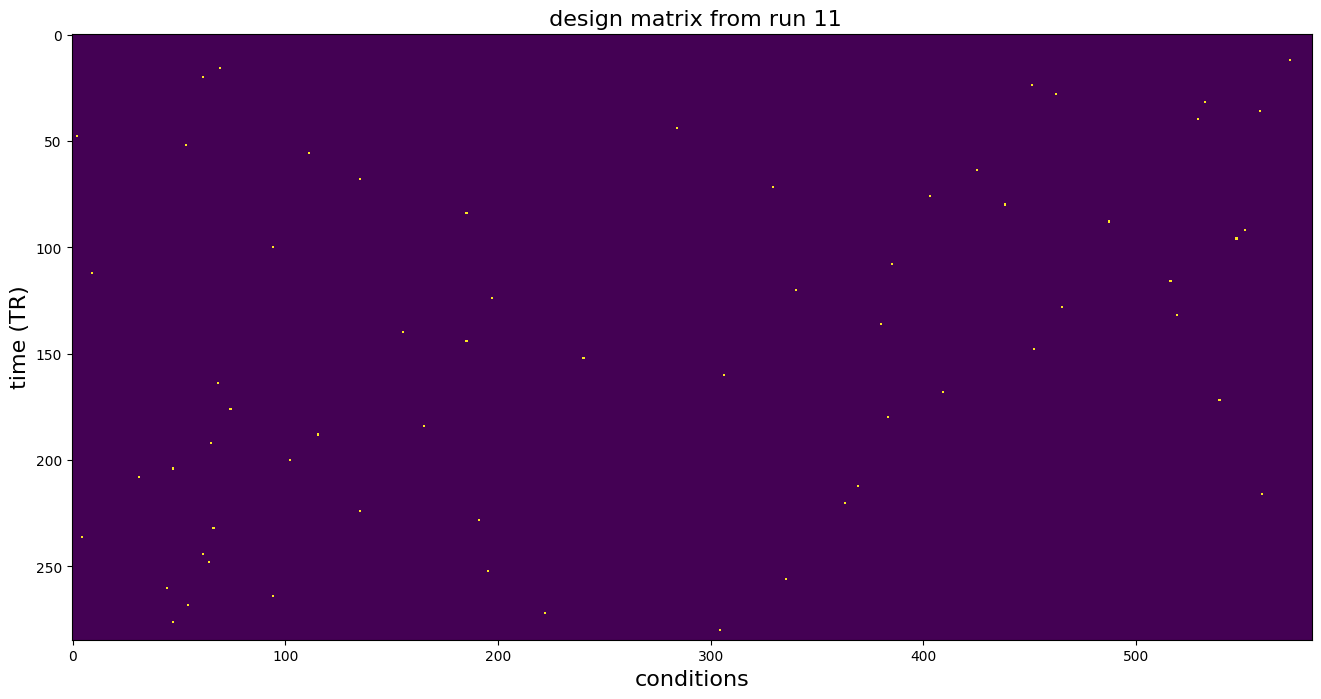

In [223]:
# Plot design matrix for each run
run=10
plt.figure(figsize=(16,16))
plt.imshow(design[run],interpolation='none')
plt.title(' design matrix from run %i' %(run+1), fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16) 

# Repeats analysis (no GLM)

In [224]:
# consolidate matrices
dataALL = np.concatenate(data,axis=1)
print('dataALL shape (features, TRs):', dataALL.shape)
designALL = np.concatenate(design,axis=0)
print('designALL shape (TRs, conditions):', designALL.shape)

dataALL shape (features, TRs): (1024, 3420)
designALL shape (TRs, conditions): (3420, 583)


In [225]:
featA, featB = None, None
for uniq_image in range(designALL.shape[1]): # loop over every condition
    if len(np.where(designALL[:,uniq_image])[0]) > 1:
        tr1, tr2 = np.where(designALL[:,uniq_image])[0][:2]
        if featA is None:
            featA = dataALL[:,tr1][None]
            featB = dataALL[:,tr2][None]
        else:
            featA = np.vstack((featA, dataALL[:,tr1][None]))
            featB = np.vstack((featB, dataALL[:,tr2][None]))

print(featA.shape, featB.shape)

(136, 1024) (136, 1024)


In [226]:
corrs = []
for i in range(len(featA)):
    corrs = np.append(corrs, np.corrcoef(featA[i], featB[i])[0][1])
print(np.mean(corrs))

rand_corrs = []
for rr in range(30):
    for i in range(len(featA)):
        j = np.random.randint(len(featA))
        rand_corrs = np.append(rand_corrs, np.corrcoef(featA[i], featB[j])[0][1])
print(np.mean(rand_corrs))

0.669530725161829
0.6136010562719441


# GLMSingle

In [103]:
# outputs and figures will be stored in a folder (you can specify its name
# as the 5th output to GLMsingle). model estimates can be also
# saved to the 'results' variable which is the only output of
# GLMsingle.

# optional parameters below can be assigned to a structure, i.e., opt =
# dict('wantlibrary':1, 'wantglmdenoise':1); options are the 6th input to
# GLMsingle.

# there are many options that can be specified; here, we comment on the
# main options that one might want to modify/set. defaults for the options
# are indicated below.

# wantlibrary = 1 -> fit HRF to each voxel 
# wantglmdenoise = 1 -> use GLMdenoise 
# wantfracridge = 1 -> use ridge regression to improve beta estimates 
# chunklen = 50000 -> is the number of voxels that we will
#    process at the same time. for setups with lower memory, you may need to 
#    decrease this number.

# wantmemoryoutputs is a logical vector [A B C D] indicating which of the
#     four model types to return in the output <results>. the user must be
#     careful with this, as large datasets can require a lot of RAM. if you
#     do not request the various model types, they will be cleared from
#     memory (but still potentially saved to disk). default: [0 0 0 1]
#     which means return only the final type-D model.

# wantfileoutputs is a logical vector [A B C D] indicating which of the
#     four model types to save to disk (assuming that they are computed). A
#     = 0/1 for saving the results of the ONOFF model, B = 0/1 for saving
#     the results of the FITHRF model, C = 0/1 for saving the results of the
#     FITHRF_GLMdenoise model, D = 0/1 for saving the results of the
#     FITHRF_GLMdenoise_RR model. default: [1 1 1 1] which means save all
#     computed results to disk.

# numpcstotry (optional) is a non-negative integer indicating the maximum
#     number of GLMdenoise PCs to enter into the model. default: 10.

# fracs (optional) is a vector of fractions that are greater than 0
#     and less than or equal to 1. we automatically sort in descending
#     order and ensure the fractions are unique. these fractions indicate
#     the regularization levels to evaluate using fractional ridge
#     regression (fracridge) and cross-validation. default:
#     fliplr(.05:.05:1). a special case is when <fracs> is specified as a
#     single scalar value. in this case, cross-validation is NOT performed
#     for the type-D model, and we instead blindly use the supplied
#     fractional value for the type-D model.

In [104]:
opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [0,0,0,1]
opt['wantmemoryoutputs'] = [1,1,1,1]
#opt['wanthdf5'] = 1

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1724249722.5607312,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [0, 0, 0, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wanthdf5': 0,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [105]:
print('shape of data before running GLMsingle:')
print(data[0].shape)
print('shape of design matrix:')
print(design[0].shape)

shape of data before running GLMsingle:
(1024, 285)
shape of design matrix:
(285, 583)


In [106]:
# Try running with brainexclude=avg_mask
# if it crashes, then increase max to 1,500,000

# this example saves output files to the outputdir folder
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

#if not exists(outputdir_glmsingle):
if run_glmsingle == 1:
    print('saving outputs to', outputdir_glmsingle)
    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle,
       figuredir=outputdir_glmsingle,
       )
    
    # save results in memory to npz
    np.savez(join(outputdir_glmsingle,'TYPEA_ONOFF.npz'), **results_glmsingle['typea'])
    np.savez(join(outputdir_glmsingle,'TYPEB_FITHRF.npz'), **results_glmsingle['typeb'])
    np.savez(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npz'), **results_glmsingle['typec'])
    np.savez(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npz'), **results_glmsingle['typed'])
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
elif run_glmsingle == 0:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    # takes about 2 minutes to load
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    
    if opt['wanthdf5'] == 1: #if outputs are in hdf5 format
        results_intm = dict()
        results_intm['typea'] = h5py.File(join(outputdir_glmsingle,'TYPEA_ONOFF.hdf5'), 'r')
        results_intm['typeb'] = h5py.File(join(outputdir_glmsingle,'TYPEB_FITHRF.hdf5'), 'r')
        results_intm['typec'] = h5py.File(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.hdf5'), 'r')
        results_intm['typed'] = h5py.File(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.hdf5'), 'r')
        
        model_types = ['typea', 'typeb', 'typec', 'typed']
        for model in range(len(model_types)):
            results_glmsingle[model_types[model]] = dict()
            plot_fields = list(results_intm[model_types[model]].keys())
    
            for i in range(len(plot_fields)):
                results_glmsingle[model_types[model]][plot_fields[i]] = results_intm[model_types[model]].get(plot_fields[i]).value
    
    else:
        results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npz'))
        results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npz'))
        results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npz'))
        results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npz'))
        
elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

saving outputs to glmsingle
running GLMsingle...
*** DIAGNOSTICS ***:
There are 12 runs.
The number of conditions in this experiment is 583.
The stimulus duration corresponding to each trial is 3.00 seconds.
The TR (time between successive data points) is 1.00 seconds.
The number of trials in each run is: [63, 62, 63, 62, 63, 62, 63, 62, 63, 62, 63, 62].
The number of trials for each condition is: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 3, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1

chunks:   0%|                                                                                                     | 0/1 [00:00<?, ?it/s]

chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.69s/it]


*** DETERMINING GLMDENOISE REGRESSORS ***

*** CROSS-VALIDATING DIFFERENT NUMBERS OF REGRESSORS ***



chunks:   0%|                                                                                                     | 0/1 [00:00<?, ?it/s]

chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:12<00:00, 72.18s/it]



*** FITTING TYPE-C MODEL (GLMDENOISE) ***



chunks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.42s/it]


*** FITTING TYPE-D MODEL (GLMDENOISE_RR) ***



chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:26<00:00, 146.24s/it]


*** Saving results to glmsingle/TYPED_FITHRF_GLMDENOISE_RR.npy. ***

*** All model types done ***

*** return model types in results ***

	elapsed time:  00:04:07


In [107]:
# convert everything back to 3D/4D array format
model_types = ['typea','typeb','typec','typed']
plot_fields = ['betasmd','meanvol', 'R2','HRFindex','FRACvalue']

models = dict()
models['assumehrf'] = results_glmsingle['typea']['betasmd']
models['fithrf'] = results_glmsingle['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle['typed']['betasmd']

In [ ]:
designALL = np.concatenate(design,axis=0)
print('designALL shape (TRs, conditions):', designALL.shape)

# construct a vector containing 0-indexed condition numbers in chronological order
corder = []
for p in range(designALL.shape[0]):
    if np.any(designALL[p]):
        corder.append(np.argwhere(designALL[p])[0,0])

corder = np.array(corder)

# let's take a look at the first few entries
print(corder[:3])

repindices = [] # 2 x images containing stimulus trial indices.

# the first row refers to the first presentation; the second row refers to second presentation.
for p in range(designALL.shape[1]): # loop over every condition
    temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
    
    # only add repeated conditions to repindices
    if len(temp) >= 2:
        repindices.append([temp[0], temp[1]]) # note that for now we only look at first 2 repetitions

repindices = np.vstack(np.array(repindices)).T
print(repindices.shape, '(repetitions, condition)')

In [108]:
vox_reliabilities = [] # output variable for reliability values

modelnames = list(models.keys())[1:]
print(modelnames)

# for each beta version...
for m in range(len(modelnames)):

    print(f'computing reliability for beta version: {modelnames[m]}')
    time.sleep(1)

    # get the repeated-condition GLM betas using our repindices variable
    betas = models[modelnames[m]][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
    # betas = models[modelnames[m]]['betasmd'][:,None,None,:][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
    x,y,z = betas.shape[:3] 

    rels = np.full((x,y,z),np.nan)

    # loop through voxels in the 3D volume...
    for xx in tqdm(range(x)):
        for yy in range(y):
            for zz in range(z):

                # reliability at a given voxel is pearson correlation between response profiles from first and 
                # second image presentations (dim = 136 conditions)
                rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                             betas[xx,yy,zz,1])[1,0]

    vox_reliabilities.append(rels)

['fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']
computing reliability for beta version: fithrf


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 18262.08it/s]


computing reliability for beta version: fithrf_glmdenoise


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 18521.81it/s]


computing reliability for beta version: fithrf_glmdenoise_rr


100%|████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [00:00<00:00, 18065.44it/s]


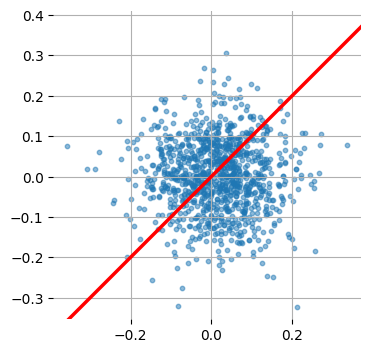

In [113]:
x_version = 'assume_hrf'
y_version = 'fithrf_glmdenoise_rr'

x = vox_reliabilities[0]
y = vox_reliabilities[-1]

plt.figure(figsize=(4,4))
plt.grid('on')
plt.scatter(x, y, 10, alpha = 0.5)
plt.axis('square')

plt.plot(np.arange(-0.6,0.7,0.01),np.arange(-0.6,0.7,0.01),'r',linewidth=2.5,zorder=10)

# get rid of the frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

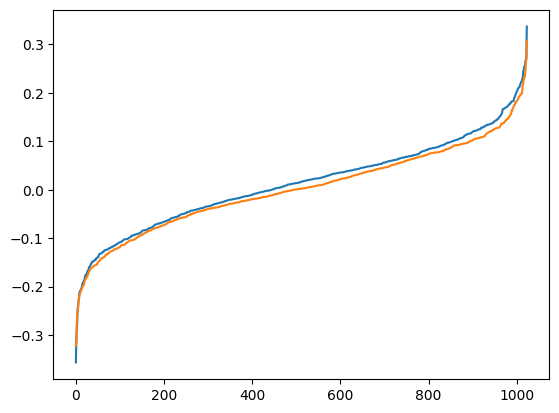

In [111]:
plt.plot(np.sort(x.flatten()))
plt.plot(np.sort(y.flatten()))
plt.show()

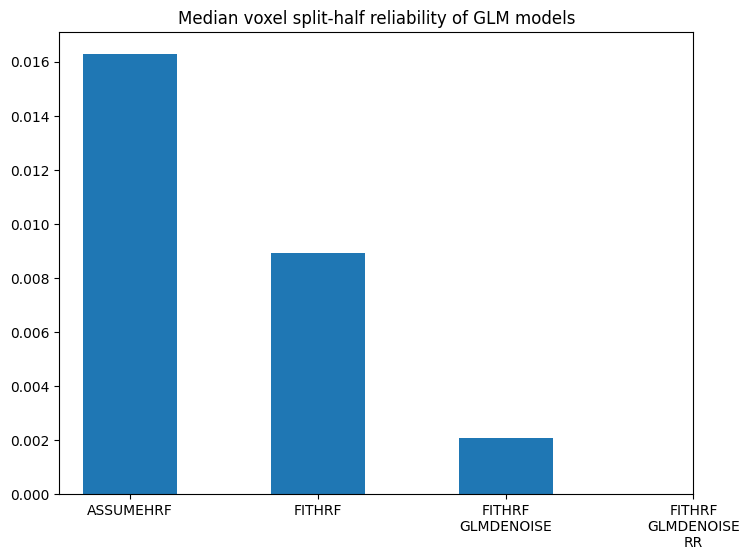

In [112]:
comparison = []
for vr in vox_reliabilities:
    comparison.append(np.nanmedian(vr)) 

plt.figure(figsize=(18,6))
plt.subplot(121)
plt.bar(np.arange(len(comparison)),comparison,width=0.5)
plt.title('Median voxel split-half reliability of GLM models')
plt.xticks(np.arange(4),np.array(['ASSUMEHRF','FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']))
plt.show()

In [233]:
featA = models['fithrf'][:,:,:,repindices][:,0,0,:,0].T
featB = models['fithrf'][:,:,:,repindices][:,0,0,:,1].T
print(featA.shape, featB.shape)

# featA = models['fithrf_glmdenoise'][:,:,:,repindices][:,0,0,:,0]
# featB = models['fithrf_glmdenoise'][:,:,:,repindices][:,0,0,:,1]
# print(featA.shape, featB.shape)

# featA = models['fithrf_glmdenoise_rr'][:,:,:,repindices][:,0,0,:,0]
# featB = models['fithrf_glmdenoise_rr'][:,:,:,repindices][:,0,0,:,1]
# print(featA.shape, featB.shape)

IndexError: index 216 is out of bounds for axis 3 with size 1

In [232]:
corrs = []
for i in range(len(featA)):
    corrs = np.append(corrs, np.corrcoef(featA[i], featB[i])[0][1])
print(np.mean(corrs))

rand_corrs = []
for rr in range(100):
    for i in range(len(featA)):
        j = np.random.randint(len(featA))
        rand_corrs = np.append(rand_corrs, np.corrcoef(featA[i], featB[j])[0][1])
print(np.mean(rand_corrs))

0.04544183752052509
0.02759615004686638
